In [1]:
#import typical ML libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

#importing useful python libraries
import string #use string.punctuation in preprocessing 
string.punctuation += "“"
from collections import Counter #use Counter function to easily find most common 

import matplotlib
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag_sents
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jdahh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jdahh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jdahh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## PREPROCESSING 
We need to import the data and convert it to a matrix of features. Our features will be the presence of the most common words in each message.

44898 samples in our dataset
We have far too many samples for this to run on my consumer desktop, so I will take a small sample for the training and test data.
4490 samples in our dataset
better!


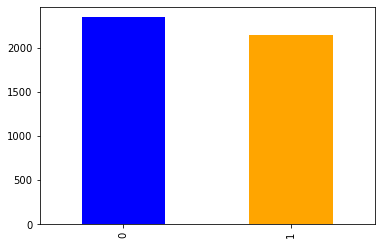

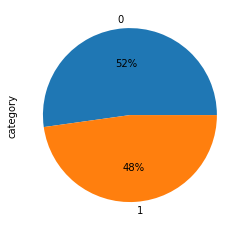

In [2]:
lemmatizer = WordNetLemmatizer() # importing lemmatizer function, as it would be impossible to implement
STOP_WORDS = stopwords.words('english') # importing stopwords (can't list them off of the top of my head), turning to a set so access is faster
STOP_WORDS.append('reuters')
STOP_WORDS = set(STOP_WORDS)
"""
data = pd.read_csv("emails.csv").dropna()
X = data["text"]
y = data["spam"]
print(X)
print(y)
"""
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")
true['category'] = 1
false['category'] = 0
data = pd.concat([true,false])
data['text'] = data['text'] + " " + data['title']

print(len(data), "samples in our dataset")
print("We have far too many samples for this to run on my consumer desktop, so I will take a small sample for the training and test data.")

data = data.sample(frac = 1/10)

print(len(data), "samples in our dataset")
print("better!")
count_Class = pd.value_counts(data["category"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title = 'Bar chart'
plt.show()
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title = 'Pie chart'
plt.ylabel = ''
plt.show()

X = data['text']
y = data['category']

In [3]:
def get_wordnet_pos(treebank_tag):
    # we need to convert the part of speech from the POS_tagger to one that our lemmatizer will accept
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [4]:
def complete_lemmatizer(text):
    # this takes a list of words as an input and batch lemmatizes all of them, using the lemmatizer and pos_tag functions
    ret = []
    tagged = pos_tag_sents(text)
    for tag in tagged:
        word, POS = tag[0]
        POS = get_wordnet_pos(POS)
        if POS:
            ret.append(lemmatizer.lemmatize(word, pos = POS))
        else:
            ret.append(lemmatizer.lemmatize(word))
    return ret

In [5]:
def is_valid(word): 
    # need to filter out insignificant words
    if len(word) < 2:
        return False
    if word in STOP_WORDS:
        return False
    return True

In [6]:
def create_list(train_data, size): 
    # we want to create a list of the most common words, we can change the size (num features) to avoid overfitting
    big_list = []
    copy_list = []
    i = 0
    for text in train_data:
        mid_list = []
        words = text.split()
        for word in words:
            word = word.strip(string.punctuation).lower()
            if is_valid(word):
                mid_list.append([word])
        lemmatized = complete_lemmatizer(mid_list)
        big_list += lemmatized 
        copy_list.append(lemmatized)
    return Counter(big_list).most_common(size), copy_list

In [7]:
def create_dict(train_data, size):
    # we convert the list of common words into a dict to make it easier to query when we create features matrix 
    big_list, copy_list = create_list(train_data, size)
    big_dict = {}
    for i in range(len(big_list)):
        big_dict[big_list[i][0]] = (big_list[i][1], i)
    return big_dict, copy_list

In [8]:
def create_features(data_list, words_dict):
    # we create a feature matrix where each of the common words is a feature, and each sample has the count of each word in each feature
    features_matrix = np.zeros((len(data_list), len(words_dict)))
    text_id = 0
    for text in data_list:
        for word in text:
            if word in words_dict:
                features_matrix[text_id, words_dict[word][1]] += 1
        text_id += 1
    return features_matrix

In [9]:
def preprocess_data(data, size, words_dict = None):
    # for training data, returns a features matrix and word_dict, for test data, accepts words_dict and returns features matrix
    words_dict2, copy_list = create_dict(data, size) 
    if words_dict:
        return create_features(copy_list, words_dict)
    else:
        return create_features(copy_list, words_dict2), words_dict2

In [10]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size = .5)
X_train, words_dict = preprocess_data(X_train_raw, 3000)
words_list = list(words_dict.keys())
words_array = np.array(words_list)
X_test = preprocess_data(X_test_raw, 3000, words_dict)
print(words_dict)

{'say': (8992, 0), 'trump': (6245, 1), 'state': (3078, 2), 'would': (2883, 3), 'u.s': (2697, 4), 'president': (2660, 5), 'make': (2045, 6), 'people': (2020, 7), 'republican': (1979, 8), 'one': (1946, 9), 'year': (1742, 10), 'go': (1716, 11), 'take': (1663, 12), 'also': (1583, 13), 'new': (1551, 14), 'obama': (1489, 15), 'government': (1461, 16), 'clinton': (1439, 17), 'get': (1431, 18), 'time': (1430, 19), 'house': (1422, 20), 'united': (1372, 21), 'donald': (1347, 22), 'campaign': (1325, 23), 'could': (1313, 24), 'call': (1294, 25), 'country': (1279, 26), 'american': (1256, 27), 'like': (1254, 28), 'election': (1231, 29), 'told': (1201, 30), 'white': (1135, 31), 'party': (1103, 32), 'official': (1078, 33), 'last': (1061, 34), 'come': (1052, 35), 'news': (1034, 36), 'want': (1027, 37), 'even': (1013, 38), 'know': (1012, 39), 'two': (1003, 40), 'include': (1002, 41), 'use': (1000, 42), 'report': (996, 43), 'right': (982, 44), 'group': (979, 45), 'work': (974, 46), 'former': (941, 47), '

## UNSUPERVISED ANALYSIS
Now we will perform some unsupervised analysis. We will be graphing the clusters in 2 and 3 dimensions using the first 2 and 3 most common features. We will also see if the k-means algorithm can come up with different results depending on whether or not the features are scaled.

SEEING IF KMEANS CAN CORRECTLY IDENTIFY OUR LABELS
X = say Y = trump Z = state
ACCURACY = 0.4365256124721604

KMEANS ESTIMATE


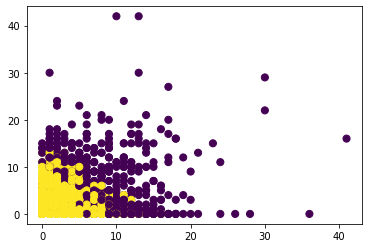


ACTUAL LABELS


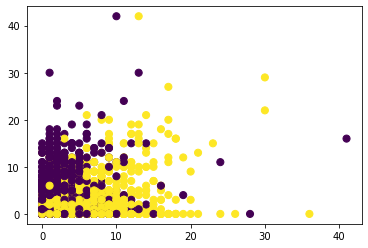

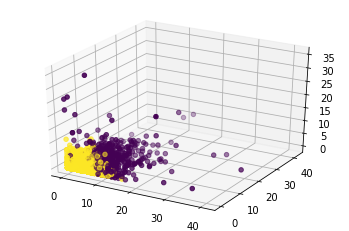

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
w1 = (words_list[0])
w2 = (words_list[1])
w3 = (words_list[2])
print("SEEING IF KMEANS CAN CORRECTLY IDENTIFY OUR LABELS")
print("X = " + w1 + " Y = " + w2 + " Z = " +w3)
kmeans = KMeans(n_clusters = 2).fit(X_train)
acc = accuracy_score(y_train, kmeans.labels_)
print("ACCURACY =", acc)
print("\nKMEANS ESTIMATE")

plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.show()
print("\nACTUAL LABELS")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='viridis')
plt.show()
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')
plt3d.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c = kmeans.labels_)
plt.show()


LOOKING FOR TRENDS


K = 3
X = say Y = trump Z = state


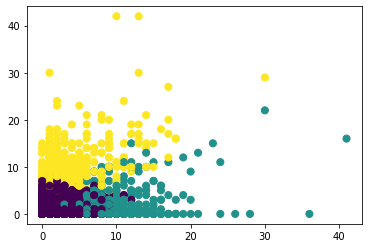

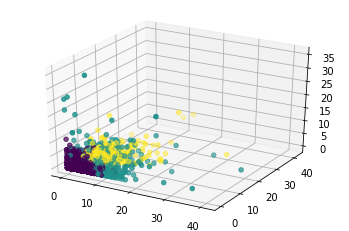



K = 4
X = say Y = trump Z = state


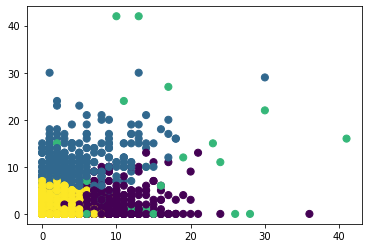

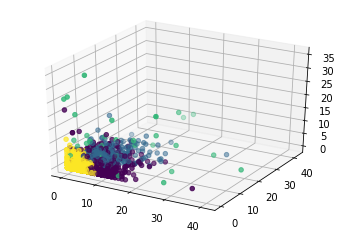



K = 5
X = say Y = trump Z = state


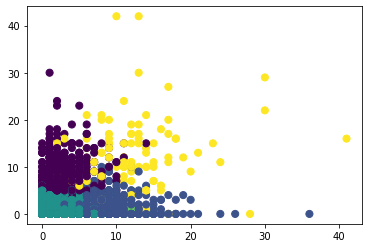

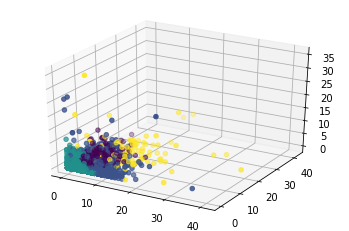



K = 6
X = say Y = trump Z = state


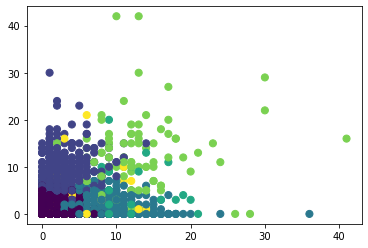

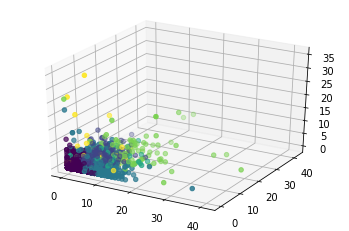



K = 7
X = say Y = trump Z = state


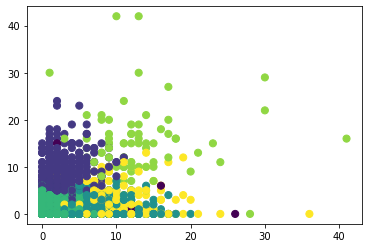

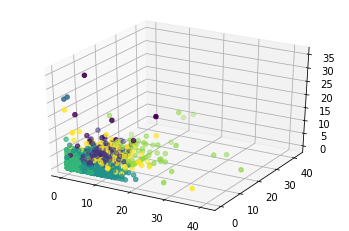



K = 8
X = say Y = trump Z = state


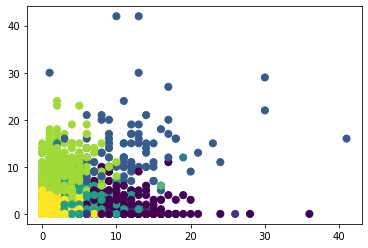

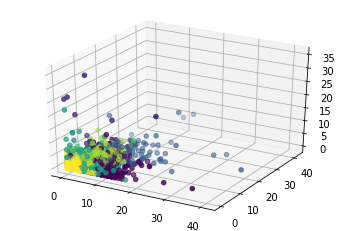



K = 9
X = say Y = trump Z = state


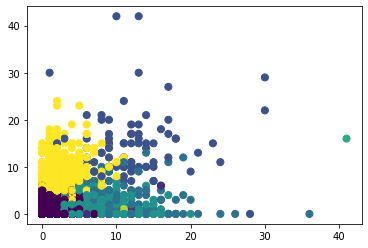

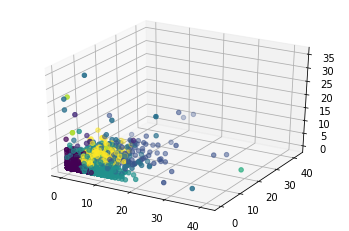



K = 10
X = say Y = trump Z = state


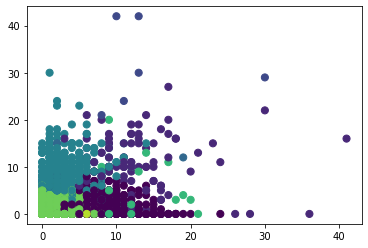

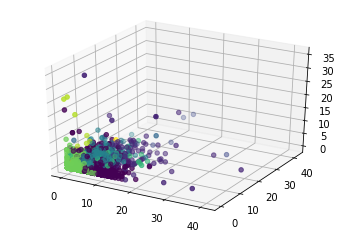

In [12]:
def kmeans_analysis(k):
    print("\n\nK =",k)
    print("X = " + w1 + " Y = " + w2 + " Z = " +w3)
    kmeans = KMeans(n_clusters = k).fit(X_train)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
    plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c = kmeans.labels_)
    plt.show()

print("LOOKING FOR TRENDS")
for i in range(3,11):
    kmeans_analysis(i)

Now let's see what happens when we mean center and scale our features, and try k means again

In [13]:
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)

SEEING IF KMEANS CAN CORRECTLY IDENTIFY OUR LABELS
X = say Y = trump Z = state
ACCURACY = 0.49888641425389757

KMEANS ESTIMATE


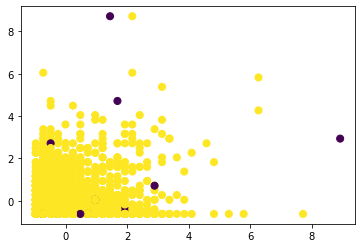


ACTUAL LABELS


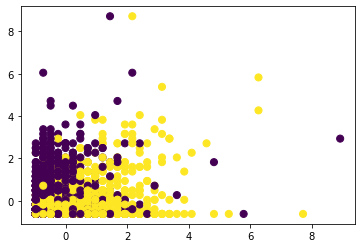

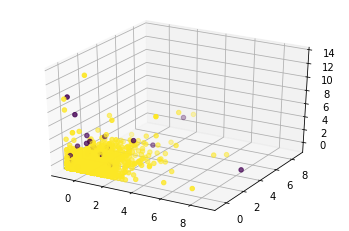

LOOKING FOR TRENDS


K = 3
X = say Y = trump Z = state


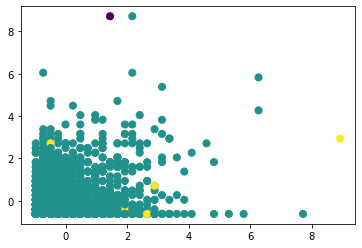

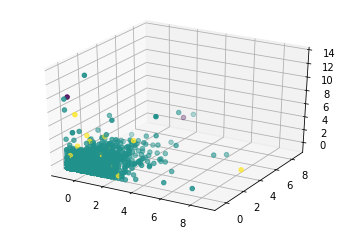



K = 4
X = say Y = trump Z = state


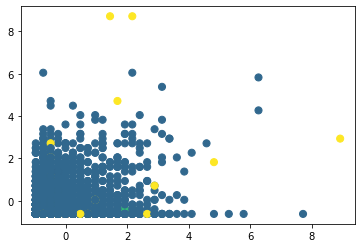

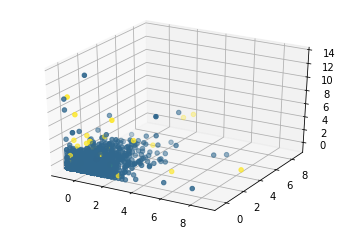



K = 5
X = say Y = trump Z = state


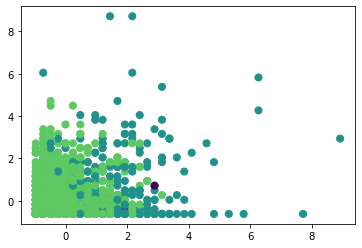

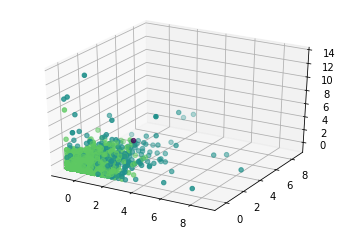



K = 6
X = say Y = trump Z = state


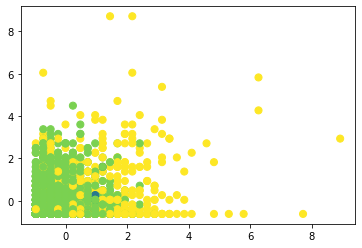

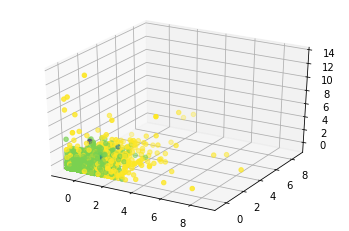



K = 7
X = say Y = trump Z = state


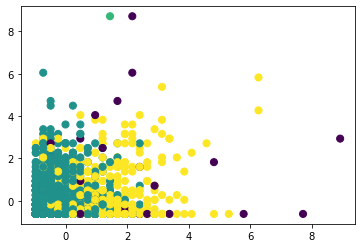

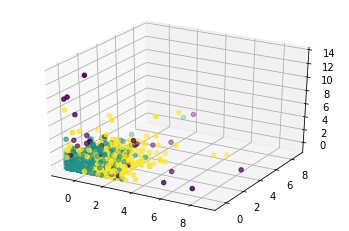



K = 8
X = say Y = trump Z = state


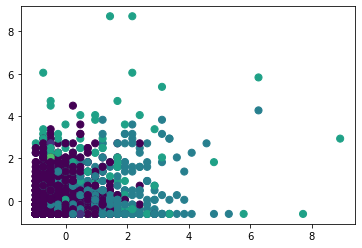

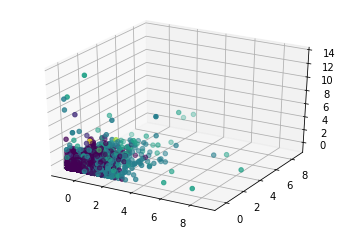



K = 9
X = say Y = trump Z = state


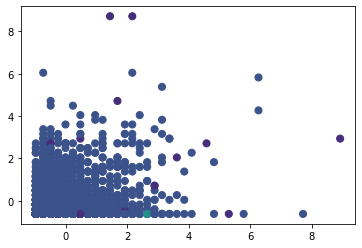

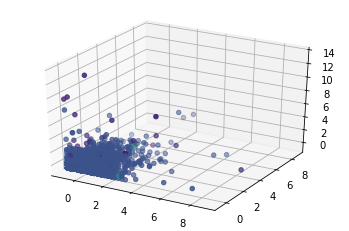



K = 10
X = say Y = trump Z = state


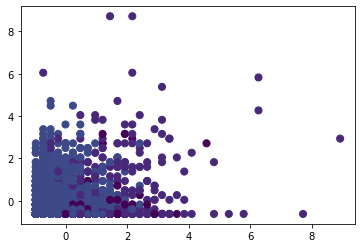

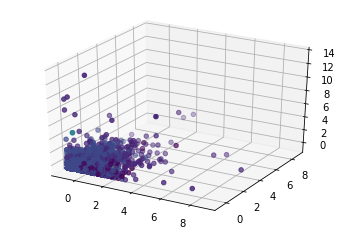

In [14]:
w1 = (words_list[0])
w2 = (words_list[1])
w3 = (words_list[2])
print("SEEING IF KMEANS CAN CORRECTLY IDENTIFY OUR LABELS")
print("X = " + w1 + " Y = " + w2 + " Z = " +w3)
kmeans = KMeans(n_clusters = 2).fit(X_train)
acc = accuracy_score(y_train, kmeans.labels_)
print("ACCURACY =", acc)
print("\nKMEANS ESTIMATE")

plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.show()
print("\nACTUAL LABELS")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='viridis')
plt.show()
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')
plt3d.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c = kmeans.labels_)
plt.show()
print("LOOKING FOR TRENDS")
for i in range(3,11):
    kmeans_analysis(i)

Nothing particularly interesting...

## LOGISTIC REGRESSION
We will first try by using the sklearn logistic regression model. We will do this with various regularization values.

In [15]:
from sklearn.linear_model import LogisticRegression
cVals = [0.001, 0.01, 0.1, 1, 10]
tVals = [.2, .3, .4, .5, .6, .7, .8]

In [16]:
def logreg_testing(tVals, cVals, X_train, X_test, y_train, y_test, regression):
    test_acc_lst = []
    train_acc_lst = []
    for c in cVals:
        logist_model = LogisticRegression(C = c, max_iter = 10000, penalty = regression, solver = 'saga')
        logist_model.fit(X_train, y_train)
        train_predict = logist_model.predict_proba(X_train)
        test_predict = logist_model.predict_proba(X_test)
        print("##############################################")
        print("C =", c)
        for t in tVals:
            print("Threshold =", t)       
            y_hat_train = np.where(train_predict[:,1] > t, 1, 0)
            train_acc = accuracy_score(y_train, y_hat_train)
            print("TRAINING ACCURACY =", train_acc)
            y_hat_test = np.where(test_predict[:,1] > t, 1, 0)
            test_acc = accuracy_score(y_test, y_hat_test)
            print("TESTING ACCURACY =", test_acc,"\nConfusion Matrix for test:")
            print(confusion_matrix(y_test, y_hat_test))
            print()
            if t == .5:
                test_acc_lst.append(test_acc)
                train_acc_lst.append(train_acc)
        weights = np.abs(logist_model.coef_)
        sorted_index = np.argsort(weights)
        top_5 = sorted_index[:5]
        top_5_weights = weights[0][top_5]
        top_5_words = words_array[top_5]
        top_5s = list(zip(top_5_words[0], top_5_weights[0]))[::-1][:5]
        x = [word for word, _ in top_5s]
        y = [weight for _, weight in top_5s]
        plt.bar(x, y)
        plt.xlabel =("Words")
        plt.ylabel =("Weights")
        plt.title = ("Top 5 Features and Weights C = " + str(c))
        plt.show()
        
    return (test_acc_lst, train_acc_lst)

LOGISTIC REGRESSION WITH RIDGE REGRESSION
##############################################
C = 0.001
Threshold = 0.2
TRAINING ACCURACY = 0.8374164810690423
TESTING ACCURACY = 0.7768374164810691 
Confusion Matrix for test:
[[ 700  500]
 [   1 1044]]

Threshold = 0.3
TRAINING ACCURACY = 0.9167037861915367
TESTING ACCURACY = 0.8570155902004455 
Confusion Matrix for test:
[[ 881  319]
 [   2 1043]]

Threshold = 0.4
TRAINING ACCURACY = 0.9625835189309577
TESTING ACCURACY = 0.9158129175946548 
Confusion Matrix for test:
[[1017  183]
 [   6 1039]]

Threshold = 0.5
TRAINING ACCURACY = 0.9955456570155902
TESTING ACCURACY = 0.9674832962138085 
Confusion Matrix for test:
[[1146   54]
 [  19 1026]]

Threshold = 0.6
TRAINING ACCURACY = 0.9879732739420936
TESTING ACCURACY = 0.957238307349666 
Confusion Matrix for test:
[[1172   28]
 [  68  977]]

Threshold = 0.7
TRAINING ACCURACY = 0.9367483296213809
TESTING ACCURACY = 0.8922048997772829 
Confusion Matrix for test:
[[1190   10]
 [ 232  813]]

Threshol

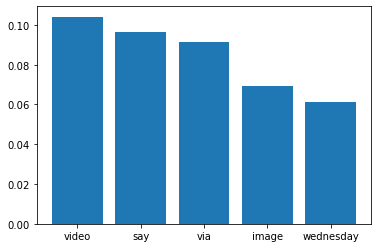

##############################################
C = 0.01
Threshold = 0.2
TRAINING ACCURACY = 0.9719376391982183
TESTING ACCURACY = 0.8939866369710467 
Confusion Matrix for test:
[[ 965  235]
 [   3 1042]]

Threshold = 0.3
TRAINING ACCURACY = 0.9928730512249443
TESTING ACCURACY = 0.9291759465478842 
Confusion Matrix for test:
[[1049  151]
 [   8 1037]]

Threshold = 0.4
TRAINING ACCURACY = 0.9991091314031181
TESTING ACCURACY = 0.9581291759465479 
Confusion Matrix for test:
[[1121   79]
 [  15 1030]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9661469933184855 
Confusion Matrix for test:
[[1149   51]
 [  25 1020]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9643652561247216 
Confusion Matrix for test:
[[1160   40]
 [  40 1005]]

Threshold = 0.7
TRAINING ACCURACY = 0.9977728285077951
TESTING ACCURACY = 0.9541202672605791 
Confusion Matrix for test:
[[1178   22]
 [  81  964]]

Threshold = 0.8
TRAINING ACCURACY = 0.9844097995545658
TESTING ACCURACY = 0.9184

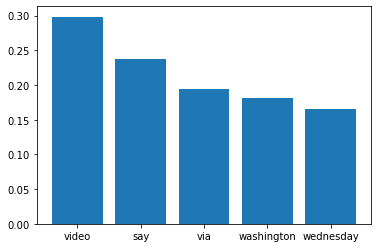

##############################################
C = 0.1
Threshold = 0.2
TRAINING ACCURACY = 0.9991091314031181
TESTING ACCURACY = 0.9367483296213809 
Confusion Matrix for test:
[[1068  132]
 [  10 1035]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9536748329621381 
Confusion Matrix for test:
[[1111   89]
 [  15 1030]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9608017817371938 
Confusion Matrix for test:
[[1133   67]
 [  21 1024]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9625835189309577 
Confusion Matrix for test:
[[1145   55]
 [  29 1016]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9616926503340757 
Confusion Matrix for test:
[[1152   48]
 [  38 1007]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9594654788418708 
Confusion Matrix for test:
[[1165   35]
 [  56  989]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9510022271714922 
Confusion Matrix for test:
[[1175   25]
 [  85 

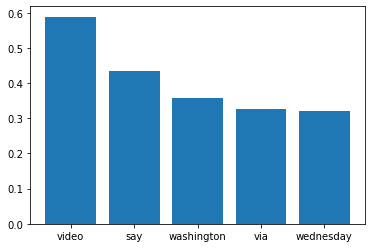

##############################################
C = 1
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9478841870824053 
Confusion Matrix for test:
[[1097  103]
 [  14 1031]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9590200445434298 
Confusion Matrix for test:
[[1126   74]
 [  18 1027]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9608017817371938 
Confusion Matrix for test:
[[1137   63]
 [  25 1020]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9616926503340757 
Confusion Matrix for test:
[[1143   57]
 [  29 1016]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9603563474387528 
Confusion Matrix for test:
[[1150   50]
 [  39 1006]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9581291759465479 
Confusion Matrix for test:
[[1156   44]
 [  50  995]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9527839643652561 
Confusion Matrix for test:
[[1168   32]
 [  74  971]]



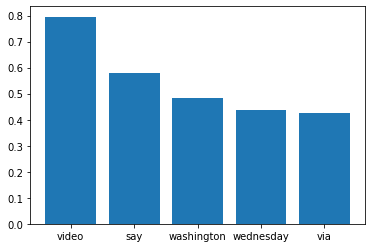

##############################################
C = 10
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9510022271714922 
Confusion Matrix for test:
[[1105   95]
 [  15 1030]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9594654788418708 
Confusion Matrix for test:
[[1127   73]
 [  18 1027]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9608017817371938 
Confusion Matrix for test:
[[1137   63]
 [  25 1020]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9616926503340757 
Confusion Matrix for test:
[[1143   57]
 [  29 1016]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9603563474387528 
Confusion Matrix for test:
[[1150   50]
 [  39 1006]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9581291759465479 
Confusion Matrix for test:
[[1155   45]
 [  49  996]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9532293986636972 
Confusion Matrix for test:
[[1167   33]
 [  72  973]]



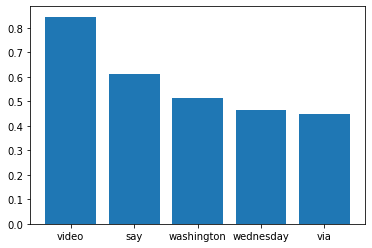

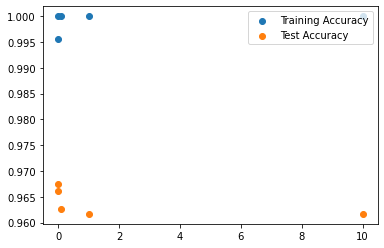

In [17]:
print("LOGISTIC REGRESSION WITH RIDGE REGRESSION")
test_acc_lst, train_acc_lst = logreg_testing(tVals, cVals, X_train, X_test, y_train, y_test, 'l2')
plt.scatter(cVals, train_acc_lst)
plt.scatter(cVals, test_acc_lst)
plt.xlabel = "C Values"
plt.ylabel = "Accuracy"
plt.legend(["Training Accuracy", "Test Accuracy"], loc = "upper right")

LOGISTIC REGRESSION WITH LASSO REGRESSION
##############################################
C = 0.001
Threshold = 0.2
TRAINING ACCURACY = 0.4904231625835189
TESTING ACCURACY = 0.46547884187082406 
Confusion Matrix for test:
[[   0 1200]
 [   0 1045]]

Threshold = 0.3
TRAINING ACCURACY = 0.4904231625835189
TESTING ACCURACY = 0.46547884187082406 
Confusion Matrix for test:
[[   0 1200]
 [   0 1045]]

Threshold = 0.4
TRAINING ACCURACY = 0.4904231625835189
TESTING ACCURACY = 0.46547884187082406 
Confusion Matrix for test:
[[   0 1200]
 [   0 1045]]

Threshold = 0.5
TRAINING ACCURACY = 0.5095768374164811
TESTING ACCURACY = 0.534521158129176 
Confusion Matrix for test:
[[1200    0]
 [1045    0]]

Threshold = 0.6
TRAINING ACCURACY = 0.5095768374164811
TESTING ACCURACY = 0.534521158129176 
Confusion Matrix for test:
[[1200    0]
 [1045    0]]

Threshold = 0.7
TRAINING ACCURACY = 0.5095768374164811
TESTING ACCURACY = 0.534521158129176 
Confusion Matrix for test:
[[1200    0]
 [1045    0]]

Thresho

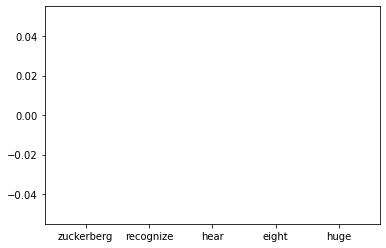

##############################################
C = 0.01
Threshold = 0.2
TRAINING ACCURACY = 0.7069042316258352
TESTING ACCURACY = 0.6908685968819599 
Confusion Matrix for test:
[[ 510  690]
 [   4 1041]]

Threshold = 0.3
TRAINING ACCURACY = 0.7817371937639198
TESTING ACCURACY = 0.7679287305122494 
Confusion Matrix for test:
[[ 687  513]
 [   8 1037]]

Threshold = 0.4
TRAINING ACCURACY = 0.8721603563474387
TESTING ACCURACY = 0.866815144766147 
Confusion Matrix for test:
[[ 913  287]
 [  12 1033]]

Threshold = 0.5
TRAINING ACCURACY = 0.9233853006681515
TESTING ACCURACY = 0.9198218262806236 
Confusion Matrix for test:
[[1049  151]
 [  29 1016]]

Threshold = 0.6
TRAINING ACCURACY = 0.9015590200445435
TESTING ACCURACY = 0.8984409799554566 
Confusion Matrix for test:
[[1126   74]
 [ 154  891]]

Threshold = 0.7
TRAINING ACCURACY = 0.7732739420935412
TESTING ACCURACY = 0.7884187082405345 
Confusion Matrix for test:
[[1172   28]
 [ 447  598]]

Threshold = 0.8
TRAINING ACCURACY = 0.6592427616926

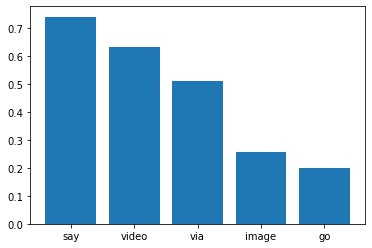

##############################################
C = 0.1
Threshold = 0.2
TRAINING ACCURACY = 0.9483296213808463
TESTING ACCURACY = 0.910467706013363 
Confusion Matrix for test:
[[1004  196]
 [   5 1040]]

Threshold = 0.3
TRAINING ACCURACY = 0.978619153674833
TESTING ACCURACY = 0.9385300668151447 
Confusion Matrix for test:
[[1072  128]
 [  10 1035]]

Threshold = 0.4
TRAINING ACCURACY = 0.9897550111358575
TESTING ACCURACY = 0.9501113585746103 
Confusion Matrix for test:
[[1101   99]
 [  13 1032]]

Threshold = 0.5
TRAINING ACCURACY = 0.9951002227171493
TESTING ACCURACY = 0.9639198218262807 
Confusion Matrix for test:
[[1137   63]
 [  18 1027]]

Threshold = 0.6
TRAINING ACCURACY = 0.9951002227171493
TESTING ACCURACY = 0.9714922048997773 
Confusion Matrix for test:
[[1161   39]
 [  25 1020]]

Threshold = 0.7
TRAINING ACCURACY = 0.9884187082405346
TESTING ACCURACY = 0.9639198218262807 
Confusion Matrix for test:
[[1170   30]
 [  51  994]]

Threshold = 0.8
TRAINING ACCURACY = 0.963919821826280

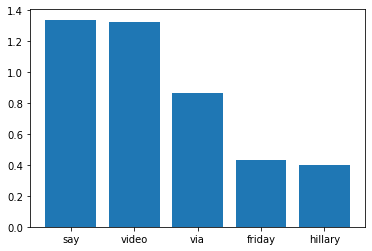

##############################################
C = 1
Threshold = 0.2
TRAINING ACCURACY = 0.9991091314031181
TESTING ACCURACY = 0.9518930957683742 
Confusion Matrix for test:
[[1100  100]
 [   8 1037]]

Threshold = 0.3
TRAINING ACCURACY = 0.999554565701559
TESTING ACCURACY = 0.9612472160356348 
Confusion Matrix for test:
[[1121   79]
 [   8 1037]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9692650334075724 
Confusion Matrix for test:
[[1142   58]
 [  11 1034]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9706013363028954 
Confusion Matrix for test:
[[1149   51]
 [  15 1030]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9723830734966592 
Confusion Matrix for test:
[[1158   42]
 [  20 1025]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9714922048997773 
Confusion Matrix for test:
[[1167   33]
 [  31 1014]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9616926503340757 
Confusion Matrix for test:
[[1176  

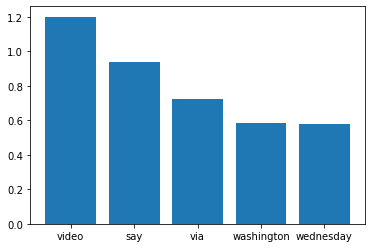

##############################################
C = 10
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9510022271714922 
Confusion Matrix for test:
[[1103   97]
 [  13 1032]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9594654788418708 
Confusion Matrix for test:
[[1125   75]
 [  16 1029]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9625835189309577 
Confusion Matrix for test:
[[1137   63]
 [  21 1024]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9625835189309577 
Confusion Matrix for test:
[[1143   57]
 [  27 1018]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9625835189309577 
Confusion Matrix for test:
[[1152   48]
 [  36 1009]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9608017817371938 
Confusion Matrix for test:
[[1159   41]
 [  47  998]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9541202672605791 
Confusion Matrix for test:
[[1167   33]
 [  70  975]]



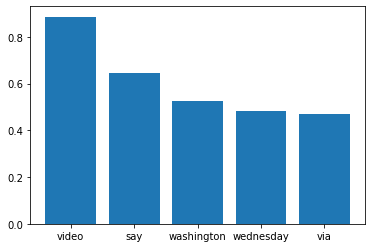

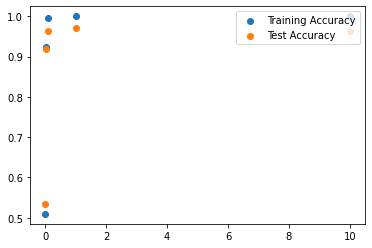

In [18]:
print("LOGISTIC REGRESSION WITH LASSO REGRESSION")
test_acc_lst, train_acc_lst = logreg_testing(tVals, cVals, X_train, X_test, y_train, y_test, 'l1')
plt.scatter(cVals, train_acc_lst)
plt.scatter(cVals, test_acc_lst)
plt.xlabel = "C Values"
plt.ylabel = "Accuracy"
plt.legend(["Training Accuracy", "Test Accuracy"], loc = "upper right")

## SVM
Now we will attempt to solve the same problem using SVMs, hoping that at least one of the different kernels (linear, polynomial, and RBF) will yield a more accurate result.

In [19]:
from sklearn import svm

In [20]:
def SVM_testing(k, tVals, cVals, X_train, X_test, y_train, y_test):
    test_acc_lst = []
    train_acc_lst = []
    print(k, "kernel\n")
    for c in cVals:
        print("##############################################")
        print("C =", c)
        SVM_model = svm.SVC(kernel = k, C = c, probability = True)
        SVM_model.fit(X_train, y_train)
        train_predict = SVM_model.predict_proba(X_train)
        test_predict = SVM_model.predict_proba(X_test)
        for t in tVals:
            print("Threshold =", t)
            y_hat_train = np.where(train_predict[:,1] > t, 1, 0)
            train_acc = accuracy_score(y_train, y_hat_train)
            print("TRAINING ACCURACY =", train_acc)
            y_hat_test = np.where(test_predict[:,1] > t, 1, 0)
            test_acc = accuracy_score(y_test, y_hat_test)
            print("TESTING ACCURACY =", test_acc,"\nConfusion Matrix for test:")
            print(confusion_matrix(y_test, y_hat_test))
            print()
            if t == .5:
                test_acc_lst.append(test_acc)
                train_acc_lst.append(train_acc)
        if k == "linear":
            weights = np.abs(SVM_model.coef_)
            sorted_index = np.argsort(weights)
            top_5 = sorted_index[:5]
            top_5_weights = weights[0][top_5]
            top_5_words = words_array[top_5]
            top_5s = list(zip(top_5_words[0], top_5_weights[0]))[::-1][:5]
            x = [word for word, _ in top_5s]
            y = [weight for _, weight in top_5s]
            plt.bar(x, y)
            plt.xlabel = "Words"
            plt.ylabel = "Weights"
            plt.title = "Top 5 Features and Weights C = " + str(c)
            plt.show()
    return (test_acc_lst, train_acc_lst)

In [21]:
def SVM_poly_testing(c, tVals, pVals, X_train, X_test, y_train, y_test):
    test_acc_lst = []
    train_acc_lst = []
    for p in pVals:
        print("##############################################")
        print("Degree =", p)
        SVM_model = svm.SVC(kernel = 'poly', C = c, degree = p, probability = True)
        SVM_model.fit(X_train, y_train)
        train_predict = SVM_model.predict_proba(X_train)
        test_predict = SVM_model.predict_proba(X_test)
        for t in tVals:
            print("Threshold =", t)
            y_hat_train = np.where(train_predict[:,1] > t, 1, 0)
            train_acc = accuracy_score(y_train, y_hat_train)
            print("TRAINING ACCURACY =", train_acc)
            y_hat_test = np.where(test_predict[:,1] > t, 1, 0)
            test_acc = accuracy_score(y_test, y_hat_test)
            print("TESTING ACCURACY =", test_acc,"\nConfusion Matrix for test:")
            print(confusion_matrix(y_test, y_hat_test))
            print()
            if t == .5:
                test_acc_lst.append(test_acc)
                train_acc_lst.append(train_acc)
    return (test_acc_lst, train_acc_lst)

linear kernel

##############################################
C = 0.001
Threshold = 0.2
TRAINING ACCURACY = 0.9906458797327394
TESTING ACCURACY = 0.9278396436525612 
Confusion Matrix for test:
[[1059  141]
 [  21 1024]]

Threshold = 0.3
TRAINING ACCURACY = 0.9951002227171493
TESTING ACCURACY = 0.9469933184855234 
Confusion Matrix for test:
[[1106   94]
 [  25 1020]]

Threshold = 0.4
TRAINING ACCURACY = 0.9986636971046771
TESTING ACCURACY = 0.9608017817371938 
Confusion Matrix for test:
[[1143   57]
 [  31 1014]]

Threshold = 0.5
TRAINING ACCURACY = 0.999554565701559
TESTING ACCURACY = 0.9665924276169265 
Confusion Matrix for test:
[[1159   41]
 [  34 1011]]

Threshold = 0.6
TRAINING ACCURACY = 0.999554565701559
TESTING ACCURACY = 0.9661469933184855 
Confusion Matrix for test:
[[1165   35]
 [  41 1004]]

Threshold = 0.7
TRAINING ACCURACY = 0.9991091314031181
TESTING ACCURACY = 0.9621380846325167 
Confusion Matrix for test:
[[1170   30]
 [  55  990]]

Threshold = 0.8
TRAINING ACCURACY = 

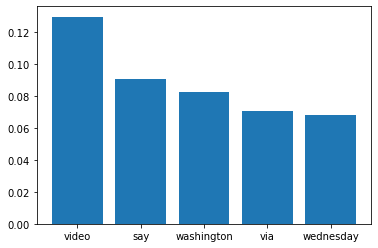

##############################################
C = 0.01
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9265033407572383 
Confusion Matrix for test:
[[1050  150]
 [  15 1030]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9443207126948775 
Confusion Matrix for test:
[[1094  106]
 [  19 1026]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9487750556792873 
Confusion Matrix for test:
[[1112   88]
 [  27 1018]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9474387527839644 
Confusion Matrix for test:
[[1125   75]
 [  43 1002]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9425389755011135 
Confusion Matrix for test:
[[1139   61]
 [  68  977]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9371937639198218 
Confusion Matrix for test:
[[1152   48]
 [  93  952]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9189309576837417 
Confusion Matrix for test:
[[1167   33]
 [ 149  896]]



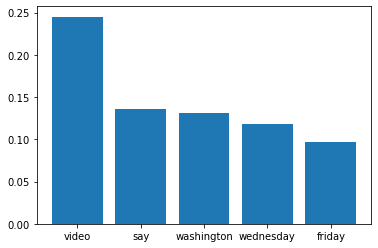

##############################################
C = 0.1
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9220489977728286 
Confusion Matrix for test:
[[1037  163]
 [  12 1033]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9376391982182628 
Confusion Matrix for test:
[[1080  120]
 [  20 1025]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9420935412026726 
Confusion Matrix for test:
[[1098  102]
 [  28 1017]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9398663697104677 
Confusion Matrix for test:
[[1121   79]
 [  56  989]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9363028953229399 
Confusion Matrix for test:
[[1137   63]
 [  80  965]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9300668151447662 
Confusion Matrix for test:
[[1151   49]
 [ 108  937]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9020044543429844 
Confusion Matrix for test:
[[1165   35]
 [ 185  860]]



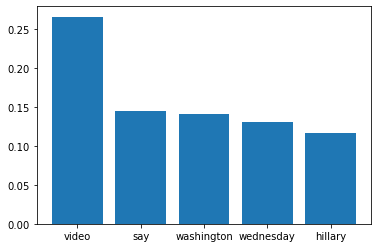

##############################################
C = 1
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9211581291759465 
Confusion Matrix for test:
[[1035  165]
 [  12 1033]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9376391982182628 
Confusion Matrix for test:
[[1080  120]
 [  20 1025]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9416481069042316 
Confusion Matrix for test:
[[1095  105]
 [  26 1019]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9403118040089087 
Confusion Matrix for test:
[[1120   80]
 [  54  991]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9367483296213809 
Confusion Matrix for test:
[[1137   63]
 [  79  966]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9305122494432071 
Confusion Matrix for test:
[[1150   50]
 [ 106  939]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9033407572383073 
Confusion Matrix for test:
[[1165   35]
 [ 182  863]]



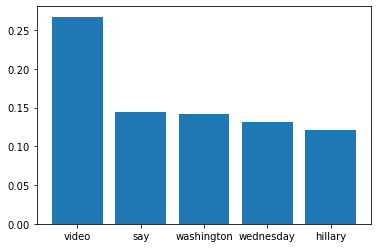

##############################################
C = 10
Threshold = 0.2
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9229398663697105 
Confusion Matrix for test:
[[1041  159]
 [  14 1031]]

Threshold = 0.3
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9380846325167038 
Confusion Matrix for test:
[[1084  116]
 [  23 1022]]

Threshold = 0.4
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9429844097995546 
Confusion Matrix for test:
[[1102   98]
 [  30 1015]]

Threshold = 0.5
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9403118040089087 
Confusion Matrix for test:
[[1125   75]
 [  59  986]]

Threshold = 0.6
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9358574610244988 
Confusion Matrix for test:
[[1138   62]
 [  82  963]]

Threshold = 0.7
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.9278396436525612 
Confusion Matrix for test:
[[1153   47]
 [ 115  930]]

Threshold = 0.8
TRAINING ACCURACY = 1.0
TESTING ACCURACY = 0.8988864142538976 
Confusion Matrix for test:
[[1169   31]
 [ 196  849]]



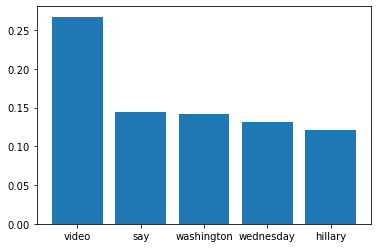

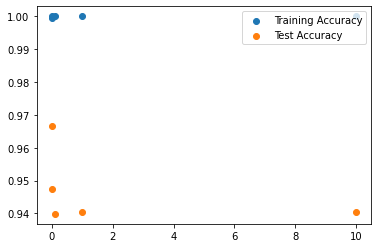

In [22]:
test_acc_lst, train_acc_lst = SVM_testing("linear", tVals, cVals, X_train, X_test, y_train, y_test)
plt.scatter(cVals, train_acc_lst)
plt.scatter(cVals, test_acc_lst)
plt.xlabel = "C Values"
plt.ylabel = "Accuracy"
plt.legend(["Training Accuracy", "Test Accuracy"], loc = "upper right")

poly kernel

##############################################
C = 0.001
Threshold = 0.2
TRAINING ACCURACY = 0.4904231625835189
TESTING ACCURACY = 0.46547884187082406 
Confusion Matrix for test:
[[   0 1200]
 [   0 1045]]

Threshold = 0.3
TRAINING ACCURACY = 0.4904231625835189
TESTING ACCURACY = 0.46547884187082406 
Confusion Matrix for test:
[[   0 1200]
 [   0 1045]]

Threshold = 0.4
TRAINING ACCURACY = 0.4904231625835189
TESTING ACCURACY = 0.46547884187082406 
Confusion Matrix for test:
[[   0 1200]
 [   0 1045]]

Threshold = 0.5
TRAINING ACCURACY = 0.5095768374164811
TESTING ACCURACY = 0.534521158129176 
Confusion Matrix for test:
[[1200    0]
 [1045    0]]

Threshold = 0.6
TRAINING ACCURACY = 0.5095768374164811
TESTING ACCURACY = 0.534521158129176 
Confusion Matrix for test:
[[1200    0]
 [1045    0]]

Threshold = 0.7
TRAINING ACCURACY = 0.5095768374164811
TESTING ACCURACY = 0.534521158129176 
Confusion Matrix for test:
[[1200    0]
 [1045    0]]

Threshold = 0.8
TRAINING ACCURACY = 

ValueError: x and y must be the same size

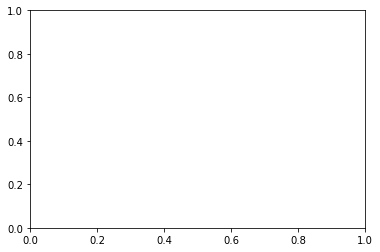

In [23]:
test_acc_lst, train_acc_lst = SVM_testing("poly", tVals, cVals + [100], X_train, X_test, y_train, y_test)
plt.scatter(cVals, train_acc_lst)
plt.scatter(cVals, test_acc_lst)
plt.xlabel = "C Values"
plt.ylabel = "Accuracy"
plt.legend(["Training Accuracy", "Test Accuracy"], loc = "upper right")

Pretty bad right? The default degree of the polynomial kernel is 3, we will try a few more with the best performing C value to see if we can improve that. 

In [ ]:
max_test_ind = test_acc_lst.index(max(test_acc_lst))
SVM_poly_testing(cVals[max_test_ind], tVals, [4,5,6,7], X_train, X_test, y_train, y_test)

In [ ]:
test_acc_lst, train_acc_lst = SVM_testing("rbf", tVals, cVals, X_train, X_test, y_train, y_test)
plt.scatter(cVals, train_acc_lst)
plt.scatter(cVals, test_acc_lst)
plt.xlabel = "C Values"
plt.ylabel = "Accuracy"
plt.legend(["Training Accuracy", "Test Accuracy"], loc = "upper right")

## NEURAL NETWORK
Now we will attempt to solve the problem using neural networks. We will try varying numbers of layers to see how it affects accuracy. 

In [ ]:
from sklearn.neural_network import MLPClassifier
lVals = [(100,), (100,100), (1000,), (1000, 1000)] 

In [ ]:
def NN_testing(tVals, lVals, cVals, X_train, X_test, y_train, y_test):
    test_acc_lst = []
    train_acc_lst = []
    for l in lVals:
        print("CURRENT LAYER CONFIGURATION:", l)
        current_test = []
        current_train = []
        for c in cVals:
            NN_model = MLPClassifier(alpha = c, hidden_layer_sizes = l)
            NN_model.fit(X_train, y_train)
            train_predict = NN_model.predict_proba(X_train)
            test_predict = NN_model.predict_proba(X_test)
            print("##############################################")
            print("alpha =", c)
            for t in tVals:
                print("Threshold =", t)       
                y_hat_train = np.where(train_predict[:,1] > t, 1, 0)
                train_acc = accuracy_score(y_train, y_hat_train)
                print("TRAINING ACCURACY =", train_acc)
                y_hat_test = np.where(test_predict[:,1] > t, 1, 0)
                test_acc = accuracy_score(y_test, y_hat_test)
                print("TESTING ACCURACY =", test_acc,"\nConfusion Matrix for test:")
                print(confusion_matrix(y_test, y_hat_test))
                print()
                if t == .5:
                    current_test.append(test_acc)
                    current_train.append(train_acc)
        test_acc_lst.append(current_test)
        train_acc_lst.append(current_train)
    return (test_acc_lst, train_acc_lst)

In [ ]:
test_acc_lst, train_acc_lst = NN_testing(tVals, lVals, cVals, X_train, X_test, y_train, y_test)


In [ ]:
for i in range(len(train_acc_lst)):
    plt.scatter(cVals, train_acc_lst[i])
    plt.scatter(cVals, test_acc_lst[i])
    plt.title = "Performance with layers " + str(lVals[i])
    plt.xlabel = "Degrees"
    plt.ylabel = "Accuracy"
    plt.legend(["Training Accuracy", "Test Accuracy"], loc = "upper right")
    plt.show()

## FEATURE MODIFICATIONS
Finally, we can try to see if we have accidentally selected too many features. If we notice test accuracy increase as we decrease the number of features, we will know that we were overfitting. We will only test the most accurate models for this part of the experiment. 

In [ ]:
print(X_train.shape)
print(X_train[:,:5].shape)
for i in (3000, 2000, 1000, 500):
    print("SIZE OF FEATURES MATRIX:", i)
    curr_test = X_test[:,:i]
    curr_train = X_train[:,:i]
    print("LOGREG")
    logreg_testing(tVals, [1], curr_train, curr_test, y_train, y_test, "l1")
    print("SVM")
    SVM_testing("linear", tVals, [.001], curr_train, curr_test, y_train, y_test)
    print("NN")
    NN_testing(tVals, (100,), [.1], curr_train, curr_test, y_train, y_test)

    